In [51]:
from datetime import datetime, timezone

from client.kalshi_client import AuthedApiInstance
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set seaborn style
sns.set_theme()
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (12,6)


In [46]:
kalshi_api = AuthedApiInstance()

94b3da2c-be41-4729-85bf-c2c5e5c0d346:y4ucMzrFe8TNK5OAlhIVter5tm8rMKniGUsvBJ5jXteNf3cOls2dzz9GQ7DHzduv


In [47]:
# Get summary statistics
event_ticker = 'OSCARPIC-23'
event_response = kalshi_api.get_event(event_ticker)
market_tickers = [market.ticker for market in sorted(event_response.markets, key=lambda x: x.last_price, reverse=True)]
market_subtitles = [market.subtitle for market in sorted(event_response.markets, key=lambda x: x.last_price, reverse=True)]

# Get axis bounds
open_time = datetime.fromisoformat(event_response.markets[0].open_time)
close_time = min(datetime.fromisoformat(event_response.markets[0].close_time), datetime.now(timezone.utc))

In [48]:
price_history_by_ticker = {t: kalshi_api.get_market_history(ticker=t).history for t in market_tickers}

Computed probabilities based on historical prices

In [ ]:
times=pd.date_range(open_time, datetime(2023, 2, 1).astimezone(timezone.utc), periods=100)
filtered_times = []
raw_prices_for_each_time = []

# Get the price of each market at each time, then divide by the sum of the prices to get the porbability
for i in range(100):
    raw_prices = []
    for ticker in market_tickers:
        price_history = price_history_by_ticker[ticker]
        mid_spread_price = None
        for price_history_item in price_history:
            if datetime.fromtimestamp(price_history_item.ts).astimezone(timezone.utc) < times[i]:
                if price_history_item.yes_ask < 100 or price_history_item.yes_bid > 0:
                    mid_spread_price = (price_history_item.yes_ask + price_history_item.yes_bid) / 2
            else:
                break
        if mid_spread_price is None:
            break
        raw_prices.append(mid_spread_price)
    if len(raw_prices) != len(market_tickers):
        continue
    else:
        filtered_times.append(times[i])
        raw_prices_for_each_time.append(raw_prices)

probabilities = (np.array(raw_prices_for_each_time) / np.sum(raw_prices_for_each_time, axis=1, keepdims=True)).T

Plot

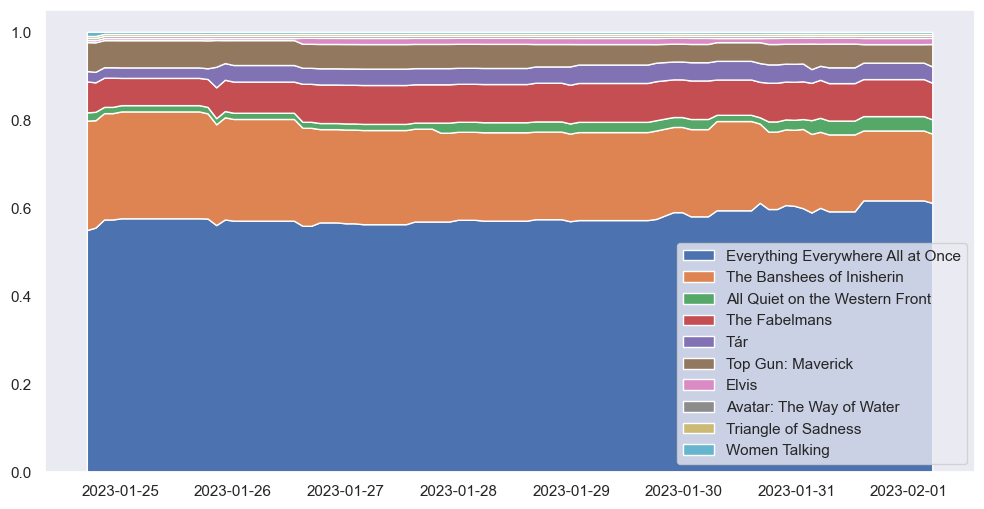

In [52]:
plt.stackplot(filtered_times, probabilities, labels=market_subtitles)
plt.legend(loc='lower right')
plt.show()